# Maternal Smoking and Birth Weight



## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_statsmodels.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_birth_weight_lower",
    "ex3_smoking_coefficient",
    "ex4_smoking_coefficient",
    "ex6_compare_white_black",
    "ex6_compare_white_black_tstat",
    "ex7_predictions",
    "ex8_smoking_coefficient",
    "ex10_num_high_drug_arrest",
    "ex11_diff_in_diff",
    "ex12_diff_in_diff_weighted",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

In [43]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Create a results dictionary
results = {}


## Exercises

For these exercises, we will borrow some data and exercises from another MIDS course on Statistical Modeling:

These days, it is widely understood that mothers who smoke during pregnancy risk exposing their babies to many health problems. This was not common knowledge fifty years ago. One of the first studies that addressed the issue of pregnancy and smoking was the Child Health and Development Studies, a comprehensive study of all babies born between 1960 and 1967 at the Kaiser Foundation Hospital in Oakland, CA. The original reference for the study is Yerushalmy (1964, American Journal of Obstetrics and Gynecology, pp. 505-518). The data and a summary of the study are in Nolan and Speed (2000, Stat Labs, Chapter 10) and can be found at [the book’s website.](https://www.stat.berkeley.edu/users/statlabs/)

There were about 15,000 families in the study. We will only analyze a subset of the data, in particular 1236 male single births where the baby lived at least 28 days. The researchers interviewed mothers early in their pregnancy to collect information on socioeconomic and demographic characteristics, including an indicator of whether the mother smoked during pregnancy. The variables in the dataset are described in the [code book here](https://ids-702-f19.github.io/Course-Website/hw/hw-02.html). In this exercise, we will attempt to use this data to answer the following questions:

1. Do mothers who smoke tend to give birth to babies with lower weights than mothers who do not smoke?
2. What is a likely range for the difference in birth weights for smokers and non-smokers?
3. Is there any evidence that the association between smoking and birth weight differs by mother’s race? If so, characterize those differences.
4. Are there other interesting associations with birth weight that are worth mentioning?


### Exercise 1
Load the data "smoking.csv", which includes information on both biometrics of infants at birth, and information on mothers (variables prefixed with the letter "m"), from [this MIDS repo](https://github.com/nickeubank/MIDS_Data). (Yup, I'm giving you CLEAN DATA! I think this is the only time I've done this in this course! Enjoy it. :)).

In [44]:
smoking = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/smoking.csv",
)

In [45]:
smoking.head()

,id,date,gestation,bwt.oz,parity,mrace,mage,med,mht,mpregwt,inc,smoke
0,4604,1598,148,116,7,7,28,1,66,135,2,0
1,7435,1527,181,110,7,7,27,1,64,133,1,0
2,7722,1563,204,55,11,7,35,3,65,140,6,0
3,2026,1503,225,132,4,7,28,2,67,148,3,0
4,3553,1638,233,105,4,7,34,3,61,130,3,0


### Exercise 2

Start by plotting the relationship between infant weight at birth and gestation (length of pregnancy (in days) at time of birth) for both mothers who smoke and those who do not in a single plot. Include regression lines for both populations (again, all on one plot).

Limit attention in the plot (and in subsequent questions) to children born after *more than* 225 days of gestation (there aren't really any observations for parents who smoke for less than that, so we don't get common support).

Does it seem like birthweights tend to be lower for the children of parents who smoke at a given gestational period? Store your answer as either `"yes"` or `"no"` in `ex2_birth_weight_lower`.

**NOTE:** This dataset has at least one column name that cause issues with Python (and seaborn. and statsmodels).

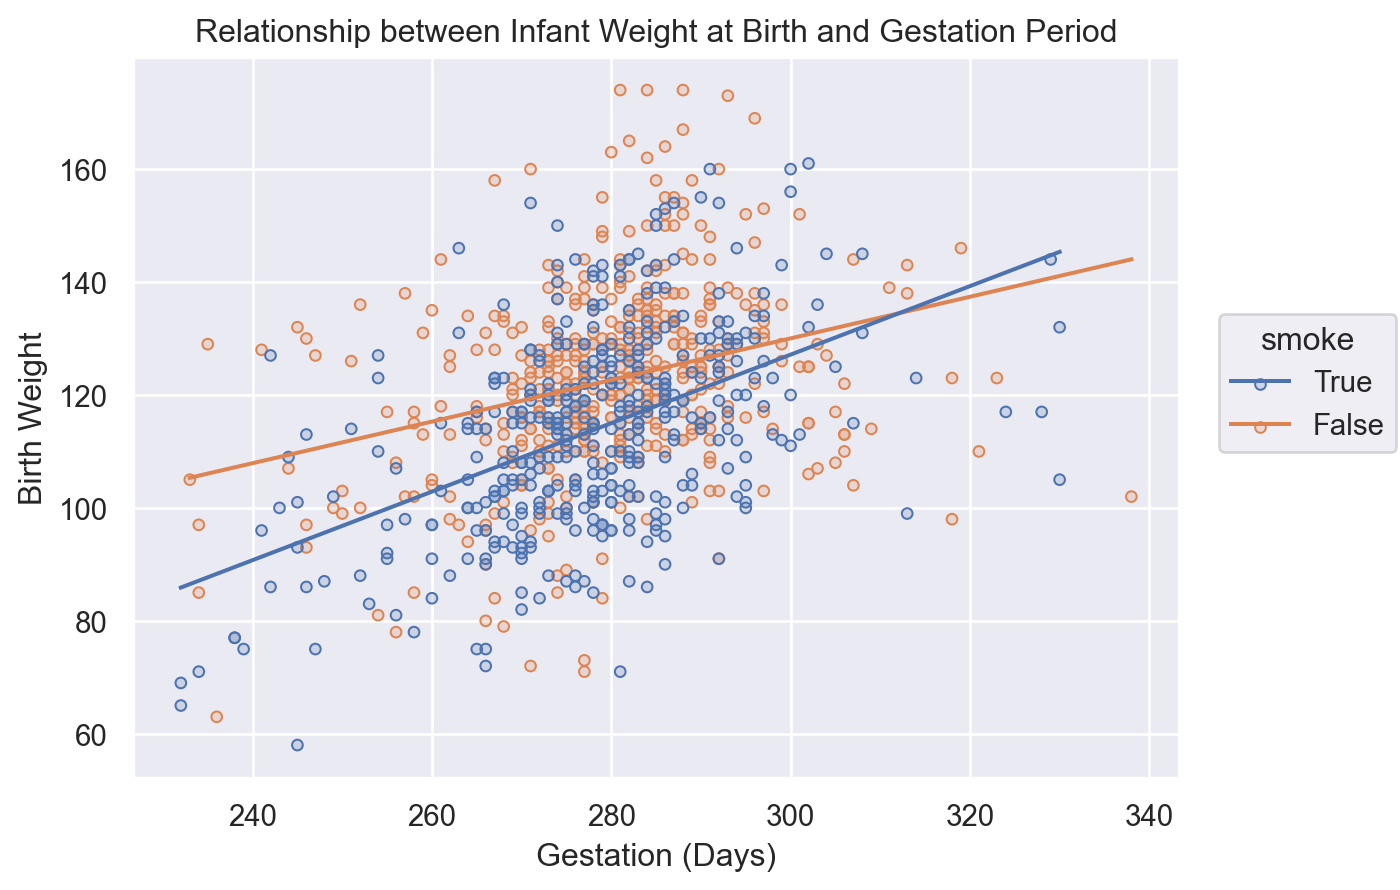

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so

# Filtering the data to include only gestation periods longer than 225 days
smoking_225 = smoking[smoking["gestation"] > 225]

# Converting the smoke column to a boolean
smoking_225["smoke"] = smoking_225["smoke"].astype("bool")

(
    so.Plot(
        smoking_225,
        y="bwt.oz",
        x="gestation",
        color="smoke",
    )
    .add(so.Dots())
    .add(so.Lines(), so.PolyFit(order=1))
    .label(
        y="Birth Weight",
        x="Gestation (Days)",
        title="Relationship between Infant Weight at Birth and Gestation Period",
    )
)

In [47]:
results["ex2_birth_weight_lower"] = "yes"

> From the graph, it seems like the birthweights tend to be lower for the children of parents who smoke at a given gestational period, especially when considering gestational periods up to approximately 315 days.

## Linear Regression

**PLEASE CONTINUE TO SUBSET FOR GESTATION GREATER THAN 225 DAYS for this section**

### Exercise 3
Now check this relationship using `statsmodels`. Regress birthweight on gestational period and whether the infant's mother smoked. Is your conclusion from the previous exercise confirmed? Store the coefficient for smoking in results under the key `"ex3_smoking_coefficient"`. 

*Note:* coefficients are stored in the `.params` attribute of your fit model.

*Note 2:* you may hit a problem because of the name of one of your columns. You should probably be able to guess the problem given your experience with Python. Also, if you have trouble figuring out how to access the parameters from a fitted model, check out the docs [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html).


In [48]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

# reanme the column bwt.oz to bwt_oz
smoking_225 = smoking_225.rename(columns={"bwt.oz": "bwt_oz"})

# Regress birthweight on gestational period and whether the infant's mother smoked.
smoking_model = ols("bwt_oz ~ gestation + smoke", data=smoking_225).fit()

# Displaying the model summary
print(smoking_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 bwt_oz   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     112.6
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           3.68e-44
Time:                        22:21:49   Log-Likelihood:                -3606.9
No. Observations:                 862   AIC:                             7220.
Df Residuals:                     859   BIC:                             7234.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.4386     10.878     -1.235

In [49]:
print("model summary for coefficients:")
smoking_model.params

model summary for coefficients:


Intercept       -13.438584
smoke[T.True]    -7.878421
gestation         0.485993
dtype: float64

In [50]:
print(
    f"The coefficient for smoking is around {smoking_model.params['smoke[T.True]']:.2f}."
)
results["ex3_smoking_coefficient"] = smoking_model.params["smoke[T.True]"]

The coefficient for smoking is around -7.88.


> The coefficent for smoking is around -7.88, suggesting that smoking by the infant's mother is associated with a reduction in the infant's birth weight. My conclusion from the previous excercise that the birthweights tend to be lower for the children of parents who smoke at a given gestational period is confirmed.

### Exercise 4
Now let's expand our model to also take into account mothers' pregnancy weight and race (make sure to treat race as a categorical variable!). Don't try to do any recoding of `mrace`, just turn it into a categorical. Does your interpretation of the `smoke` coefficient change? Store the new coefficient under the key `"ex4_smoking_coefficient"`.

In [51]:
# convert mother's race to categorical variable
smoking_225["mrace"] = smoking_225["mrace"].astype("category")

# Regress birthweight on gestational period and whether the infant's mother smoked.
smoking_model_2 = ols(
    "bwt_oz ~ gestation + smoke + mpregwt + mrace", data=smoking_225
).fit()

# Displaying the model summary
print(smoking_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 bwt_oz   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     24.23
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           6.80e-47
Time:                        22:21:50   Log-Likelihood:                -3580.3
No. Observations:                 862   AIC:                             7187.
Df Residuals:                     849   BIC:                             7248.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -17.3203     11.138     -1.555

In [52]:
print("model summary for coefficients:")
smoking_model_2.params

model summary for coefficients:


Intercept       -17.320334
smoke[T.True]    -7.895835
mrace[T.1]       -1.844101
mrace[T.2]       -5.629077
mrace[T.3]       -0.524913
mrace[T.4]        0.988394
mrace[T.5]       -0.672108
mrace[T.6]        4.308397
mrace[T.7]       -6.456950
mrace[T.8]       -7.176391
mrace[T.9]       -1.915299
gestation         0.441683
mpregwt           0.139554
dtype: float64

In [53]:
print(
    f"The coefficient for smoking is around {smoking_model_2.params['smoke[T.True]']:.2f}."
)

results["ex4_smoking_coefficient"] = smoking_model_2.params["smoke[T.True]"]

The coefficient for smoking is around -7.90.


> The coefficent for smoking is around -7.90, suggesting slightly higher reduction in the infant's birth weight causing by infant's mother's smoking comparing to the previous smoking coefficient -7.88. 

### Exercise 5
Now let's test for whether there is an interaction between the mother's race and the effect of smoking. 

Note that race is coded as follows:

```
mrace    mother’s race or ethnicity
         0-5= white
         6  = mexican
         7 = black
         8 = asian
         9 = mix
         99 = unknown
```

As most variation in this data is between "white" and other categories, first recode race to be an indicator for white and non-white for easier interpretation. 

In [54]:
# print(smoking_225["mrace"].unique())

In [55]:
# regroup the race into the white category and the non-white category in mrace column
smoking_225["mrace"] = smoking_225["mrace"].apply(lambda x: 1 if x <= 5 else 0)

# convert mother's race in the mrace column to categorical variable
smoking_225["mrace"] = smoking_225["mrace"].astype("category")

smoking_225.head()

,id,date,gestation,bwt_oz,parity,mrace,mage,med,mht,mpregwt,inc,smoke
4,3553,1638,233,105,4,0,34,3,61,130,3,False
5,3491,1705,234,85,7,0,33,1,67,130,2,False
6,6757,1444,234,97,0,0,26,5,65,112,6,False
7,6153,1405,235,129,3,0,24,4,66,135,1,False
8,8187,1669,236,63,0,1,24,5,58,99,7,False


In [56]:
# Build model to test for interaction between mother's race and the effect of smoking
smoking_model_3 = ols(
    "bwt_oz ~ gestation + mpregwt + mrace * smoke", data=smoking_225
).fit()

# Displaying the model summary
print(smoking_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 bwt_oz   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     54.81
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           1.91e-49
Time:                        22:21:50   Log-Likelihood:                -3587.5
No. Observations:                 862   AIC:                             7187.
Df Residuals:                     856   BIC:                             7216.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [57]:
print("model summary for coefficients:")
smoking_model_3.params

model summary for coefficients:


Intercept                  -21.890780
mrace[T.1]                   4.376121
smoke[T.True]               -8.860134
mrace[T.1]:smoke[T.True]     1.006944
gestation                    0.444573
mpregwt                      0.131925
dtype: float64

In [58]:
print(
    f"The interaction between white mother and the effect of smoking is around {smoking_model_3.params['mrace[T.1]:smoke[T.True]']:.2f}."
)

The interaction between white mother and the effect of smoking is around 1.01.


### Exercise 6
Now, using [post-regression test syntax](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.t_test.html) (not by running a new regression on a subpopulation), recover the coefficient and t-statistic for *whether smoking reduces birth weight for white mothers.*  Store the t-statistic of your test in `ex6_compare_white_black_tstat`.

**Hint:** Read to the BOTTOM of the post-regression test syntax documentation for how to specify hypotheses with strings.

How does this coefficient compare to that for non-white mothers? Is the reduction in birth weight associated with smoking for white mothers larger or smaller than for non-white mothers? Store your answer as either `"larger"` or `"smaller"` under the key `"ex6_compare_white_black"`.

**Note:** Please ensure your t-stat is stored as a single number, not an array or an array of arrays.

In [59]:
hyp_white = "smoke[T.True] + mrace[T.1]:smoke[T.True] = 0"
t_test_white = smoking_model_3.t_test(hyp_white)
print(t_test_white)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -7.8532      1.253     -6.266      0.000     -10.313      -5.393


In [60]:
t_value = t_test_white.tvalue.item()
print(f"The t statistics of my test is around {t_value:.2f}.")
results["ex6_compare_white_black_tstat"] = t_value

The t statistics of my test is around -6.27.


> + The hypothesis is testing whether the combined effect of smoking for white mothers is statistically different from zero.
> + The negative coefficient (c0 = -7.8532) and the t-value of -6.266 suggests that for white mothers, smoking is significantly associated with a reduction in birth weight.

In [61]:
hyp_non_white = "smoke[T.True] = 0"
t_test_non_white = smoking_model_3.t_test(hyp_non_white)
print(t_test_non_white)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -8.8601      2.077     -4.267      0.000     -12.936      -4.784


> + 7.8532 < 8.8601
> + The reduction in birth weight associated with smoking for white mothers is smaller than for non-white mothers.

In [62]:
results["ex6_compare_white_black"] = "smaller"

### Exercise 7
Now let's use this model to predict some values. Let's generate some hypothetical newborns:

```python
newborns = pd.DataFrame(
    {
        "smoke": [1, 1, 0, 0],
        "white": [True, False, True, False],
        "gestation": [253, 300, 248, 287],
        "mpregwt": [132, 129, 140, 139],
    }
)
```

Using the model you ran above with gestation, smoke, mpregwt, white, and the interaction of white and smoke, predict birth weights for these newborns. Store your predictions **in a list** under the key `"ex7_predictions"`.

Note that if you have different data types from those in this pretend dataset or different column names from those in the dataset you used to fit your model, you’ll get an error—just adjust the column names / data types to match the data you used to fit your model.

In [63]:
newborns = pd.DataFrame(
    {
        "smoke": [1, 1, 0, 0],
        "mrace": [True, False, True, False],
        "gestation": [253, 300, 248, 287],
        "mpregwt": [132, 129, 140, 139],
    }
)

In [64]:
pred_res = smoking_model_3.predict(newborns)
print(pred_res)
# print(pred_res.tolist())
results["ex7_predictions"] = pred_res.tolist()

0    104.523084
1    119.639155
2    111.208810
3    124.039095
dtype: float64


## statsmodels versus R

A quick but important note: the tools that are made available in different packages is often a function of who uses those packages, and how they use them. By and large, nearly all statisticians use R, and so many stats tools (like automatic forward-model-selection or backwards-model-selection) have "convenience implementations" (single functions that do all the things you'd want to accomplish) in R, but aren't available as convenience packages in `statsmodels`. That's because `statsmodels` was mostly written by economists and social scientists who tend to feel model selection should be a function of theory not statistical performance (not taking sides: just reporting a difference that exists). 

To be clear, you can still implement things like forward model selection yourself in Python -- just write a loop that tries different regressors and plots the resulting AICs! -- but it will often take a little more work. (Indeed, you can find examples of people [writing these loops on the web](https://planspace.org/20150423-forward_selection_with_statsmodels/)). And that's not to say that `statsmodels` doesn't have a TON of stuff (take a minute to just look over all the [examples of cool things you can do in statsmodels here](http://www.statsmodels.org/stable/examples/index.html)). Just don't be surprised if you ommissions that seem odd given what you see emphasized in stats courses. 

This is one of the reasons that languages are sticky: once a group of people have invested in adding all the bells and whistles they like to a language, there are good reasons to not move to another language, even if the other language has some advantages. A statistician who likes the basic language organization of Python more than R, for example, may still stay with R because the packages already do everything a statistician wants to do, and so it's not worth having to re-implement common tasks in a new language. 

## Logistic Regression

### Exercise 8
Now, using statsmodels, evaluate the impact of smoking on the likelihood a child is born prematurely (where "premature" is defined as gestation of *less than* 252 days).

For obvious reasons, **DO NOT USE OUR SUBSET FOR GESTATION GREATER THAN 225 DAYS** from above for this section.

For this model, please include mother’s pre-pregnancy weight, smoking status, and whether the mother is White (if you use all the racial categories, the model won’t converge). Please don’t include the interaction we used in the last question. Store the coefficient for smoking in `ex8_smoking_coefficient`.

In [65]:
smoking.head()

,id,date,gestation,bwt.oz,parity,mrace,mage,med,mht,mpregwt,inc,smoke
0,4604,1598,148,116,7,7,28,1,66,135,2,0
1,7435,1527,181,110,7,7,27,1,64,133,1,0
2,7722,1563,204,55,11,7,35,3,65,140,6,0
3,2026,1503,225,132,4,7,28,2,67,148,3,0
4,3553,1638,233,105,4,7,34,3,61,130,3,0


In [66]:
from statsmodels.formula.api import logit

# Converting the smoke column to a boolean
smoking["smoke"] = smoking["smoke"].astype("bool")

# reanme the column bwt.oz to bwt_oz
smoking = smoking.rename(columns={"bwt.oz": "bwt_oz"})

# Define premature birth as gestation less than 252 days
smoking["premature"] = smoking["gestation"].apply(lambda x: 1 if x < 252 else 0)

# Recoding race to a binary variable: 1 for White (0-5), 0 for others
smoking["mrace"] = smoking["mrace"].apply(lambda x: 1 if x <= 5 else 0)

# convert mother's race to categorical variable
smoking["mrace"] = smoking["mrace"].astype("category")

smoking.head()

,id,date,gestation,bwt_oz,parity,mrace,mage,med,mht,mpregwt,inc,smoke,premature
0,4604,1598,148,116,7,0,28,1,66,135,2,False,1
1,7435,1527,181,110,7,0,27,1,64,133,1,False,1
2,7722,1563,204,55,11,0,35,3,65,140,6,False,1
3,2026,1503,225,132,4,0,28,2,67,148,3,False,1
4,3553,1638,233,105,4,0,34,3,61,130,3,False,1


In [67]:
# Build model to evaluate the impact of smoking on the likelihood a child is born prematurely
smoking_model_4 = logit("premature ~ mpregwt + smoke + mrace", data=smoking).fit()

# Displaying the model summary
print(smoking_model_4.summary())

Optimization terminated successfully.
         Current function value: 0.187899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              premature   No. Observations:                  869
Model:                          Logit   Df Residuals:                      865
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                 0.04614
Time:                        22:21:50   Log-Likelihood:                -163.28
converged:                       True   LL-Null:                       -171.18
Covariance Type:            nonrobust   LLR p-value:                  0.001248
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5353      1.024     -1.499      0.134      -3.542       0.472
smoke[T.True]     0.

In [68]:
print("model summary for coefficients:")
smoking_model_4.params

model summary for coefficients:


Intercept       -1.535264
smoke[T.True]    0.425277
mrace[T.1]      -1.224704
mpregwt         -0.006995
dtype: float64

In [69]:
print(
    f"The coefficient for smoking is around {smoking_model_4.params['smoke[T.True]']:.2f}."
)
# store coefficient for smoking
results["ex8_smoking_coefficient"] = smoking_model_4.params["smoke[T.True]"]

The coefficient for smoking is around 0.43.


> The coefficient of smoking is around 0.43, suggests that smoking of the mother during pregnancy is associated with an increased likelihood of premature birth.

## Weighting

Let's now try using statsmodels on another dataset.

In our merging exercises, we ran a difference-in-difference analysis on crime in California counties to see if, following drug legalization, there was a larger decline in violent crime in counties that had previously also had high drug arrest rates (to test the idea that violence was being generated by the drug trade, and that legalization would decrease this violence).

In those analyses, we treated counties as equally-weighted units of analysis. If we think that each county is a single "community", and we think crime and arrests is shaped at the level of communities (particularly when our community division is related to administrative boundaries that impact policing and government services, and is the case with counties), then this is reasonable.

But one might think that crime is determined at the individual level, or maybe neighborhood level, and so big counties should "count more" in our analysis.

(More formally, when we are fitting a regression model that picks parameter values to minimize the overall sum of squared errors, maybe we should pick values that to a better job of minimizing the errors for populous counties at the expense of not doing quite as good a job of minimizing the errors for smaller counties)

Here, let's use weighted least squares to weight observations based on population. This will allow bigger counties to influence our estimates more.

### Exercise 9
To begin, read in our data on California arrest rates and population from [github](https://github.com/nickeubank/MIDS_Data/blob/master/arrest_rates_and_population.parquet). You will see I've reshaped the data to long format for convenience. This data is stored as a parquet file, so you'll need to install an engine (I usually use `fastparquet` to load the data).


In [70]:
from fastparquet import ParquetFile

url_arrest = "https://github.com/nickeubank/MIDS_Data/blob/master/arrest_rates_and_population.parquet?raw=true"
# pf_Cali = ParquetFile(url_Cali)
arrest = pd.read_parquet(url_arrest, engine="fastparquet")
arrest.head()

variable,COUNTY,year,drug_arrest_rate,total_population,violent_arrest_rate
0,Alameda County,2009,0.003946,1457095.0,0.002963
1,Alameda County,2018,0.000652,1629615.0,0.002536
2,Alpine County,2009,0.001735,1153.0,0.006938
3,Alpine County,2018,0.000831,1203.0,0.004156
4,Amador County,2009,0.002655,38039.0,0.002629


### Exercise 10
To run our difference-in-difference in a regression framework, we need both an indicator variable for observations that occur after legalization (i.e. year == 2018), and an indicator for the population we consider treated (those who had drug arrest rates above the average 2009 drug arrest rate). Re-create those here. 

As a check, store the number of counties that have a high drug arrest rate in 2009 under the key `"ex10_num_high_drug_arrest"`.

*Note:* if you want, you can also use the 2009 drug arrest rates as a continuous variable. This is a kind of "generalized difference-in-difference", in which we're just doing the continuous analogue of the thing we do when we split the sample into "high" and "low" 2009 arrest rates. 

In [71]:
# Create an indicator for observations after legalization (year >= 2018)
arrest["post_legalization"] = arrest["year"] >= 2018

# filter the year in arrest dataframe to be 2009
arrest_2009 = arrest[arrest["year"] == 2009]

# calculate the average arrest rate in 2009
average_arrest_rate_2009 = arrest_2009["drug_arrest_rate"].mean()

# Adding the "treated" column based on arrest rates higher than average in 2009
arrest_2009["treated"] = arrest_2009["drug_arrest_rate"].apply(
    lambda x: 1 if x >= average_arrest_rate_2009 else 0
)

arrest_2009[
    "treated"
].value_counts()  # 23 counties - matching with the merging exercise

treated
0    35
1    23
Name: count, dtype: int64

In [72]:
# Creating another subset with only counties higher than average in 2009
arrest_2009_high = arrest_2009[arrest_2009["treated"] == 1]

In [73]:
arrest["treated"] = arrest["COUNTY"].apply(
    lambda x: 1 if x in arrest_2009_high["COUNTY"].values else 0
)

arrest["treated"].value_counts()

treated
0    70
1    46
Name: count, dtype: int64

In [74]:
arrest.head()

variable,COUNTY,year,drug_arrest_rate,total_population,violent_arrest_rate,post_legalization,treated
0,Alameda County,2009,0.003946,1457095.0,0.002963,False,1
1,Alameda County,2018,0.000652,1629615.0,0.002536,True,1
2,Alpine County,2009,0.001735,1153.0,0.006938,False,0
3,Alpine County,2018,0.000831,1203.0,0.004156,True,0
4,Amador County,2009,0.002655,38039.0,0.002629,False,0


In [75]:
# calculate the number of counties that have a high drug arrest rate in 2009
num_counties = arrest_2009[arrest_2009["treated"] == 1].shape[0]

results["ex10_num_high_drug_arrest"] = num_counties

print(
    f"the number of counties that have a high drug arrest rate in 2009 is {num_counties}."
)

the number of counties that have a high drug arrest rate in 2009 is 23.


### Exercise 11

Now regression the violent arrest rate on your two indicators and their interaction. The coefficient on the interaction is your "difference-in-difference" estimate! If you go back to your old homeworks, you should find the coefficient is exactly what you calculated. Store this coefficient under the key  `"ex11_diff_in_diff"`.

In [76]:
# Build model to evaluate the impact of smoking on the likelihood a child is born prematurely
arrest_model = ols("violent_arrest_rate ~ post_legalization*treated", data=arrest).fit()

# Displaying the model summary
print(arrest_model.summary())

                             OLS Regression Results                            
Dep. Variable:     violent_arrest_rate   R-squared:                       0.100
Model:                             OLS   Adj. R-squared:                  0.076
Method:                  Least Squares   F-statistic:                     4.166
Date:                 Wed, 15 Nov 2023   Prob (F-statistic):            0.00773
Time:                         22:21:50   Log-Likelihood:                 630.00
No. Observations:                  116   AIC:                            -1252.
Df Residuals:                      112   BIC:                            -1241.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [77]:
print("model summary for coefficients:")
arrest_model.params

model summary for coefficients:


Intercept                            0.003403
post_legalization[T.True]           -0.000185
treated                              0.000775
post_legalization[T.True]:treated   -0.000247
dtype: float64

In [78]:
print(
    f"The interaction coefficient (difference-in-difference) estimate is around {arrest_model.params['post_legalization[T.True]:treated']:.4f}."
)
# store coefficient for smoking
results["ex11_diff_in_diff"] = arrest_model.params["post_legalization[T.True]:treated"]

The interaction coefficient (difference-in-difference) estimate is around -0.0002.


> The coefficient for diff-in-diff estimate is around -0.0002, suggesting that drug legalization is associated with a decrease in violent arrest rate.

### Exercise 12
Now let's do the same analysis, but this time using county population as a weight in a Weighted Least Squares regression (`smf.wls`). Just pass the keyword argument `weights` as a vector to weights (in this case, `arrests['total_population']`). Note that the `weights` argument is *outside* the formula, so you have to pass an actual vector of values, not just the name of a column. 

Does your interpretation of the effects of drug legalization change? Store the new difference-in-difference coefficient under the key `"ex12_diff_in_diff_weighted"`.

In [79]:
import statsmodels.formula.api as smf

arrest_model2 = smf.wls(
    "violent_arrest_rate ~ post_legalization*treated",
    data=arrest,
    weights=arrest["total_population"],
).fit()

# Displaying the model summary
print(arrest_model2.summary())

                             WLS Regression Results                            
Dep. Variable:     violent_arrest_rate   R-squared:                       0.396
Model:                             WLS   Adj. R-squared:                  0.380
Method:                  Least Squares   F-statistic:                     24.52
Date:                 Wed, 15 Nov 2023   Prob (F-statistic):           2.86e-12
Time:                         22:21:50   Log-Likelihood:                 608.13
No. Observations:                  116   AIC:                            -1208.
Df Residuals:                      112   BIC:                            -1197.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [80]:
print("model summary for coefficients:")
arrest_model2.params

model summary for coefficients:


Intercept                            0.002828
post_legalization[T.True]           -0.000359
treated                              0.001053
post_legalization[T.True]:treated   -0.000288
dtype: float64

In [81]:
results["ex12_diff_in_diff_weighted"] = arrest_model2.params[
    "post_legalization[T.True]:treated"
]
print(
    f"The Diff in diff coefficient is around {arrest_model2.params['post_legalization[T.True]:treated']:.4f}."
)

The Diff in diff coefficient is around -0.0003.


> The coefficient for diff-in-diff estimate is around -0.000288, suggesting a slightly further decrease in violent arrest rate due to drug legalization, comparing to the previous diff-in-diff estimate -0.000247.

In [82]:
assert set(results.keys()) == {
    "ex2_birth_weight_lower",
    "ex3_smoking_coefficient",
    "ex4_smoking_coefficient",
    "ex6_compare_white_black",
    "ex6_compare_white_black_tstat",
    "ex7_predictions",
    "ex8_smoking_coefficient",
    "ex10_num_high_drug_arrest",
    "ex11_diff_in_diff",
    "ex12_diff_in_diff_weighted",
}

In [83]:
# print(results)